<a href="https://colab.research.google.com/github/koad7/uol_final/blob/main/FINAL_UOL_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  transformers
!pip install -q nltk node2vec
!pip install -q haversine
!pip  install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from google.colab import drive
import os
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pickle
import copy
import numpy as np
import gc

In [3]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/')
FINAL_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/final_work')
WORKDIR_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/')

In [67]:
what = 'read'
if what == 'read':
  train_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_10_15.parquet')
  test_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_10_15.parquet')
  val_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_10_15.parquet')

  train_40_50 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_40_50.parquet')
  test_40_50 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_40_50.parquet')
  val_40_50 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_40_50.parquet')


# DATA STAT

In [68]:
train_df = train_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
val_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
test_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]


train_40_50_df = train_40_50[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
val_40_50_df = val_40_50[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]
test_40_50_df = val_40_50[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]]

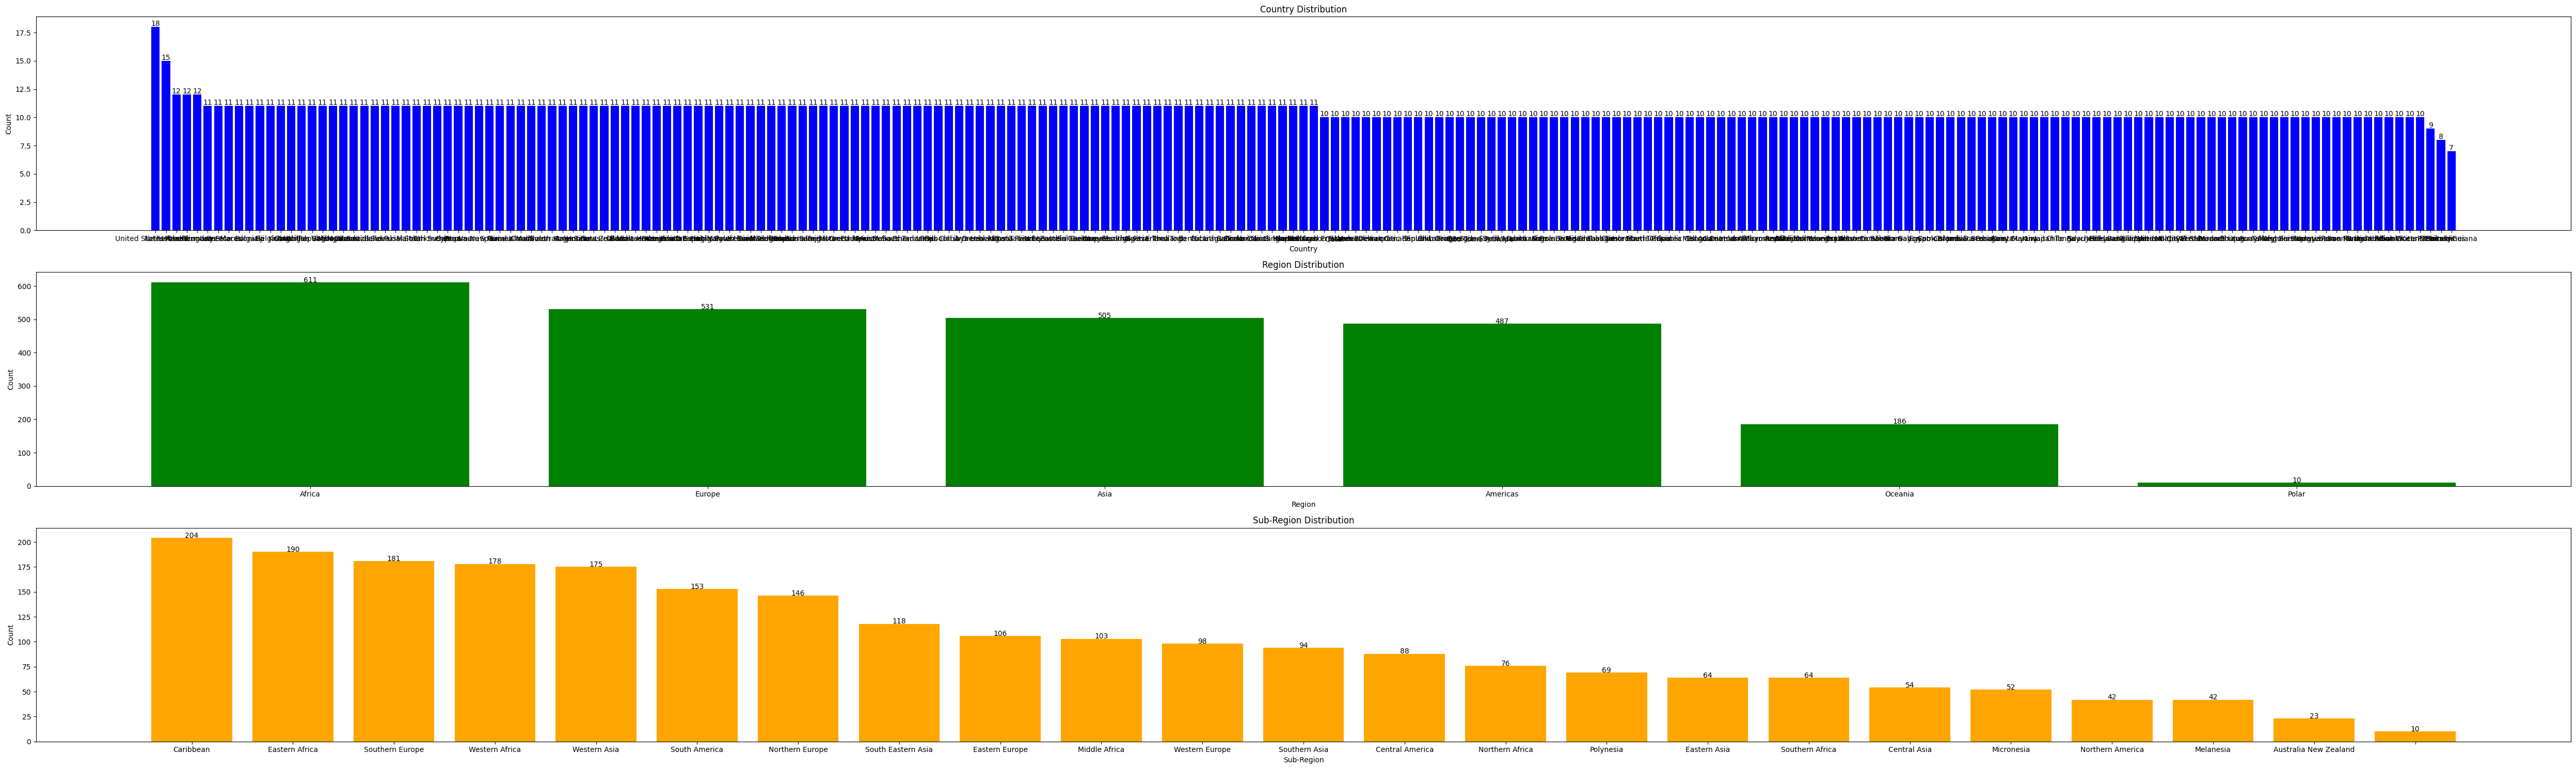

In [7]:
import matplotlib.pyplot as plt


# Calculate value counts for plotting
country_distribution = train_df['country'].value_counts()
region_distribution = train_df['region'].value_counts()
sub_region_distribution = train_df['sub_region'].value_counts()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(50, 15))

# Plot for Country Distribution
axes[0].bar(country_distribution.index, country_distribution.values, color='blue')
axes[0].set_title('Country Distribution')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Count')
for i, v in enumerate(country_distribution.values):
    axes[0].text(i, v + 0.1, str(v), ha='center')

# Plot for Region Distribution
axes[1].bar(region_distribution.index, region_distribution.values, color='green')
axes[1].set_title('Region Distribution')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')
for i, v in enumerate(region_distribution.values):
    axes[1].text(i, v + 0.1, str(v), ha='center')

# Plot for Sub-Region Distribution
axes[2].bar(sub_region_distribution.index, sub_region_distribution.values, color='orange')
axes[2].set_title('Sub-Region Distribution')
axes[2].set_xlabel('Sub-Region')
axes[2].set_ylabel('Count')
for i, v in enumerate(sub_region_distribution.values):
    axes[2].text(i, v + 0.1, str(v), ha='center')

# Show plots
plt.tight_layout()
plt.show()


# BASELINE MODELS

## Create the knowledge graph

In [8]:
def create_knowledge_graph(df):
    G = nx.DiGraph()

    for idx, row in df.iterrows():
        country = row['country']
        location = row['location']
        location_latitude = row['location_latitude']
        location_longitude = row['location_longitude']
        osm_id = row['osm_id']
        region = row['region']
        sub_region = row['sub_region']


        # Add nodes
        if pd.notna(country) and country!= '':
            G.add_node(country, country=country, type='Country')
        if pd.notna(location) and location!= '':
            G.add_node(location, location=location, type='Location', osm_id=osm_id)
        if pd.notna(location_latitude) and location_latitude!= '':
            G.add_node(location_latitude, type='Location_Latitude')
        if pd.notna(location_longitude) and location_longitude!= '':
            G.add_node(location_longitude, type='Location_Longitude')
        if pd.notna(region) and region!= '':
            G.add_node(region, region=region, type='Region')
        if pd.notna(sub_region) and sub_region!= '':
            G.add_node(sub_region, sub_region=sub_region, type='Sub_Region')

        # Add edges
        if (pd.notna(country) and country!='') and (pd.notna(location) and location!=''):
            G.add_edge(country, location, relation='has')
        if (pd.notna(location) and location!='') and (pd.notna(location_latitude) and location_latitude!=''):
            G.add_edge(location, location_latitude, relation='has_latitude')
        if (pd.notna(location) and location!='') and (pd.notna(location_longitude) and location_longitude!=''):
            G.add_edge(location, location_longitude, relation='has_longitude')
        if (pd.notna(country) and country!='') and (pd.notna(region) and region!=''):
            G.add_edge(country, region, relation='is_in')
        if (pd.notna(region) and region!='') and (pd.notna(sub_region) and sub_region!=''):
            G.add_edge(region, sub_region, relation='is_in')

    return G



    # Draw the graph

In [9]:
# Create the Knowledge Graphs
train_kg = create_knowledge_graph(train_df)
val_kg = create_knowledge_graph(val_df)
test_kg = create_knowledge_graph(test_df)

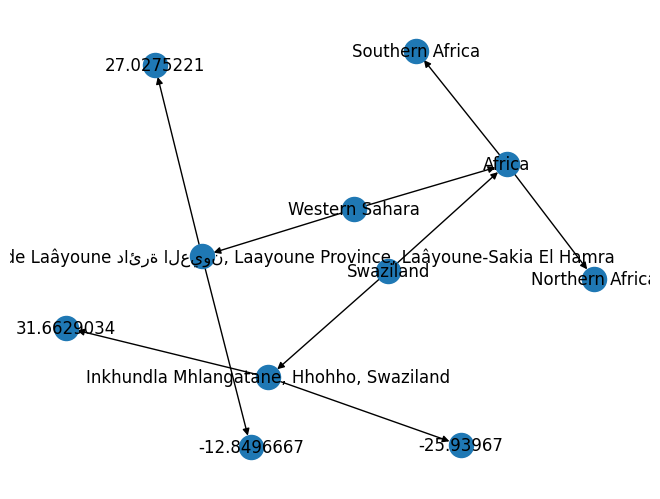

In [10]:
# Testing
G = create_knowledge_graph(train_df[:2])
nx.draw(G, with_labels=True)
plt.show()


In [11]:
import torch
torch_ver = torch.__version__
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


## Generate embeddings

### Embedding

In [12]:
from transformers import DistilBertTokenizer, DistilBertModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from threading import Thread
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import networkx as nx
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader

def generate_kge_with_distilbert(graph, batch_size=32):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased').to('cuda' if torch.cuda.is_available() else 'cpu')

    node_list = list(graph.nodes())
    node_texts = [str(node) for node in node_list]

    # Tokenize in batches
    inputs = tokenizer(node_texts, return_tensors="pt", padding=True, truncation=True)
    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    node_embeddings = {}

    model.eval()
    with torch.no_grad():
        for i, (input_ids_batch, attention_mask_batch) in enumerate(dataloader):
            input_ids_batch = input_ids_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            attention_mask_batch = attention_mask_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            for j in range(cls_embeddings.shape[0]):
                node = node_list[i * batch_size + j]
                node_embeddings[node] = cls_embeddings[j]

    return node_embeddings



In [13]:
train_emb = generate_kge_with_distilbert(train_kg)
val_emb = generate_kge_with_distilbert(val_kg)
test_emb = generate_kge_with_distilbert(test_kg)

In [14]:
len(test_emb)

1247

In [241]:
len(val_emb)

1247

In [242]:
len(train_emb)

7195

## Extract labels and other data

#### Extract data from Graph

In [24]:
def extract_data_from_graph(graph):
    # Initialize dictionaries
    country_labels = []
    location_longitude = []
    location_latitude = []
    node_types = []
    node_type_to_int = {}
    type_counter = 0
    # Collect unique node types from the graph
    unique_node_types = set(graph.nodes[node].get('type', 'Unknown') for node in graph.nodes)
    node_type_to_int = {node_type: i for i, node_type in enumerate(sorted(unique_node_types))}

    for node, data in graph.nodes(data=True):
        node_type = data.get('type', 'Unknown')
        node_types.append(node_type_to_int.get(node_type, 0))
        # Extract country labels if available
        if data.get('type') == 'Country':
            country_labels.append(node)
        # Extract location coordinates if available
        elif data.get('type') == 'Location_Longitude':
            location_longitude.append(node)
        elif data.get('type') == 'Location_Latitude':
            location_latitude.append(node)




    unique_countries = list(set(country_labels))
    country_to_int = {country: i for i, country in enumerate(unique_countries)}
    country_labels = [country_to_int[name] for name in country_labels]

    return {
            'country_labels':country_labels,
            'location_latitudes':location_latitude,
            'location_longitudes':location_longitude,
            'node_types':node_types,
            'node_type_to_int':node_type_to_int
            }


In [17]:
labels_train = extract_data_from_graph(train_kg)
labels_val = extract_data_from_graph(val_kg)
labels_test = extract_data_from_graph(test_kg)

In [251]:
len(labels_train['location_longitudes'])

2313

## Create PyG dataset

In [18]:
import torch
from torch_geometric.data import Data, Dataset

class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

def create_pyg_dataset(graph, embeddings, labels):
    data_list = []

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors
    y = torch.zeros(num_nodes, 2)  # Assuming 2D coordinates (latitude, longitude)

    for node, idx in node_to_idx.items():
        if labels.get(node):
            y[idx] = torch.tensor(labels[node], dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

    return CustomDataset(data_list)


In [19]:
def create_pyg_dataset_complexe(graph, embeddings):
    data_list = []

    # Extract data from graph
    extracted_data = extract_data_from_graph(graph)
    location_latitudes = extracted_data['location_latitudes']
    location_longitudes = extracted_data['location_longitudes']

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        print(node)
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors for latitude and longitude
    y_lat = torch.zeros(num_nodes, 1)  # Latitude
    y_lon = torch.zeros(num_nodes, 1)  # Longitude

    for node, idx in node_to_idx.items():
        if node in location_latitudes:
            y_lat[idx] = torch.tensor(float(node), dtype=torch.float)
        if node in location_longitudes:
            y_lon[idx] = torch.tensor(float(node), dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y_lat=y_lat, y_lon=y_lon)
    data_list.append(data)

    return CustomDataset(data_list)

## Build Lat Lon labels

In [20]:
def build_lat_lon_labels(df):
  labels = {}
  for idx, row in df.iterrows():
    location = row['location']
    location_latitude = row['location_latitude']
    location_longitude = row['location_longitude']

    if pd.notna(location) and pd.notna(location_latitude) and pd.notna(location_longitude):
        labels[location] = [location_latitude, location_longitude]
  return labels


In [21]:
labels_train = build_lat_lon_labels(train_df)
labels_val = build_lat_lon_labels(val_df)
labels_test = build_lat_lon_labels(test_df)

In [22]:
train_dataset = create_pyg_dataset(train_kg, train_emb, labels_train)
val_dataset = create_pyg_dataset(val_kg, val_emb, labels_val)
test_dataset = create_pyg_dataset(test_kg, test_emb, labels_test)

## Baseline  Models

#### GCN

In [29]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.fc(x)

        return x

##### Hyperparameters tuning

In [34]:
# Assume dataset is your PyG dataset and it has been split into train_dataset, val_dataset, and test_dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize model, optimizer, and data loader
num_features = train_dataset.num_features
num_classes = 2  # For latitude and longitude

In [35]:
import optuna

# Objective function to optimize
def objective(trial):
    # Hyperparameters to tune

    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    optimizer = trial.suggest_categorical("optimizer",['adam', 'sgd', 'rmsprop', 'adagrad'])
    scheduler = trial.suggest_categorical("scheduler",['none', 'step', 'cos'])

    # Initialize and train GCN model
    model = GCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(50):  # Fixed number of epochs
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)  # Assuming regression problem
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        for batch in val_loader:
            batch.to(device)
            with torch.no_grad():
                pred = model(batch)
                loss = F.mse_loss(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        val_loss /= len(val_loader.dataset)

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2023-09-27 21:06:46,128] A new study created in memory with name: no-name-7a8485af-73f0-4c0c-a4d5-668d6f5174d5
[I 2023-09-27 21:06:47,085] Trial 0 finished with value: 646.7213745117188 and parameters: {'lr': 0.003119411623755562, 'dropout': 0.36309375462553706, 'optimizer': 'adam', 'scheduler': 'none'}. Best is trial 0 with value: 646.7213745117188.
[I 2023-09-27 21:06:47,911] Trial 1 finished with value: 628.2930908203125 and parameters: {'lr': 0.005282216554234276, 'dropout': 0.34672413169924493, 'optimizer': 'adagrad', 'scheduler': 'none'}. Best is trial 1 with value: 628.2930908203125.
[I 2023-09-27 21:06:48,730] Trial 2 finished with value: 546.7434692382812 and parameters: {'lr': 0.010230125258487295, 'dropout': 0.2575518304891954, 'optimizer': 'sgd', 'scheduler': 'step'}. Best is trial 2 with value: 546.7434692382812.
[I 2023-09-27 21:06:49,542] Trial 3 finished with value: 719.5247802734375 and parameters: {'lr': 0.0005235080269344973, 'dropout': 0.49765092164262204, 'optim

Number of finished trials: 100
Best trial:
Value: 508.1834411621094
Params: 
    lr: 0.015780288865100644
    dropout: 0.45060458635074035
    optimizer: adagrad
    scheduler: cos


##### Training

In [36]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

# Assume study is your Optuna study object
best_trial = study.best_trial

best_lr = best_trial.params['lr']
best_dropout = best_trial.params['dropout']
best_optimizer = best_trial.params['optimizer']
best_scheduler = best_trial.params['scheduler']



In [37]:
num_features = train_dataset.num_features  # Replace with the number of features in your node feature matrix
num_classes = 2  # For latitude and longitude
model = GCN(num_features, num_classes).to(device)

if best_optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
elif best_optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
elif best_optimizer == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr)
elif best_optimizer == 'adagrad':
    optimizer = torch.optim.Adagrad(model.parameters(), lr=best_lr)


if best_scheduler == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
elif best_scheduler == 'cos':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=30, gamma=0.1)
elif best_scheduler == 'none':
    scheduler = None



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loss_values = []
val_loss_values = []

# Training loop
num_epochs = 400
for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    train_epoch_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item() * batch.num_graphs

    train_epoch_loss /= len(train_loader.dataset)
    train_loss_values.append(train_epoch_loss)

    # Validation loop
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_epoch_loss += loss.item() * batch.num_graphs

    val_epoch_loss /= len(val_loader.dataset)
    val_loss_values.append(val_epoch_loss)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item() * batch.num_graphs

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


TypeError: ignored

In [281]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

test_data = test_dataset.get(0).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")



MAE: 5.82259464263916, 
MSE: 153.78033447265625, 
RMSE: 12.400819778442383, 
R-Squared: 0.7650380412382747


#####  Descriptive Statistics Of the model with haversine_distances

In [65]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np
from scipy import stats

def haversine_distance(coord1, coord2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c



In [283]:

# Calculate Haversine distances for all nodes
haversine_distances = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions)])

mean_distance = np.mean(haversine_distances)
median_distance = np.median(haversine_distances)
std_dev = np.std(haversine_distances)
min_distance = np.min(haversine_distances)
max_distance = np.max(haversine_distances)
quartiles = np.percentile(haversine_distances, [25, 50, 75])
skewness = stats.skew(haversine_distances)
kurtosis = stats.kurtosis(haversine_distances)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 1031.34538174109, Median: 71.38027185205084, Std Dev: 1602.653612414024
Min: 49.691095592562746, Max: 11852.459536591172
Quartiles: [  71.38027185   71.38027185 1518.41387938]
Skewness: 2.704715976486019, Kurtosis: 10.117429345524247


## Robuste Models

### GCN


1. **Deeper Network**: Add more layers to capture more complex features.
2. **Batch Normalization**: Normalize the activations of the neurons in the hidden layers.
3. **Skip Connections**: Add skip connections to help the gradient flow during backpropagation.
4. **Different Activation Functions**: Use different activation functions like Leaky ReLU or Parametric ReLU.
5. **Regularization**: Add L2 regularization to the fully connected layers.


#### Simple GCN

In [297]:
class RobustGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(RobustGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 256)
        self.bn1 = BatchNorm(256)

        self.conv2 = GCNConv(256, 128)
        self.bn2 = BatchNorm(128)

        self.conv3 = GCNConv(128, 64)
        self.bn3 = BatchNorm(64)

        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)

        self.dropout = 0.5  # Dropout rate
        self.reg_lambda = 0.001  # L2 regularization

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Fully connected layers
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.fc2(x)

        # L2 regularization
        l2_reg = torch.tensor(0.).to(x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        x += self.reg_lambda * l2_reg

        return x

#### Robust GCN

#### GCN Hyperparameters fine tuning

In [298]:
def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 10, 100)  # Added this line

    # Initialize and train the model
    model = RobustGCN(num_features, num_classes).to(device)
    model.dropout = dropout
    model.reg_lambda = reg_lambda

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):  # Modified this line to use num_epochs
        model.train()
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Assuming val_loader is your validation DataLoader
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print(f"Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-27 14:59:29,180] A new study created in memory with name: no-name-fcca1178-a7e4-4a70-bd33-121c5aab5ee8
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2023-09-27 14:59:30,072] Trial 0 finished with value: 466.8299865722656 and parameters: {'lr': 0.02350254200636697, 'dropout': 0.42542358105886824, 'reg_lambda': 0.05306935758102647, 'batch_size': 64}. Best is trial 0 with value: 466.8299865722656.
[I 2023-09-27 14:59:30,911] Trial 1 finished with value: 758.791015625 and parameters: {'lr': 4.101143227816158e-05, 'dropout': 0.4123583972068088, 'reg_lambda': 0.024063542380695545, 'batch_size': 64}. Best is trial 0 with value: 466.8299865722656.
[I 2023-09-27 14:59:31,780] Trial 2 finished with value: 599.9681396484375 and parameters: {'lr': 0.08865056063098095, 'dropout': 0.39188488256536336, 'reg_lambda': 0.001226811537207488, 'batch_size': 32}. Best

Number of finished trials: 100
Best trial:
Value: 303.3785705566406
Params: 
    lr: 0.06758944630296944
    dropout: 0.3923714831242985
    reg_lambda: 0.09361010056341744
    batch_size: 64


In [300]:
best_rgcn_trial = study.best_trial
best_lr = best_rgcn_trial.params['lr']
best_dropout = best_rgcn_trial.params['dropout']
best_optimizer = best_rgcn_trial.params['reg_lambda']
best_batch_size = best_rgcn_trial.params['batch_size']

Training: 100%|██████████| 500/500 [00:15<00:00, 32.96epoch/s]


Test Loss: 166.8305206298828


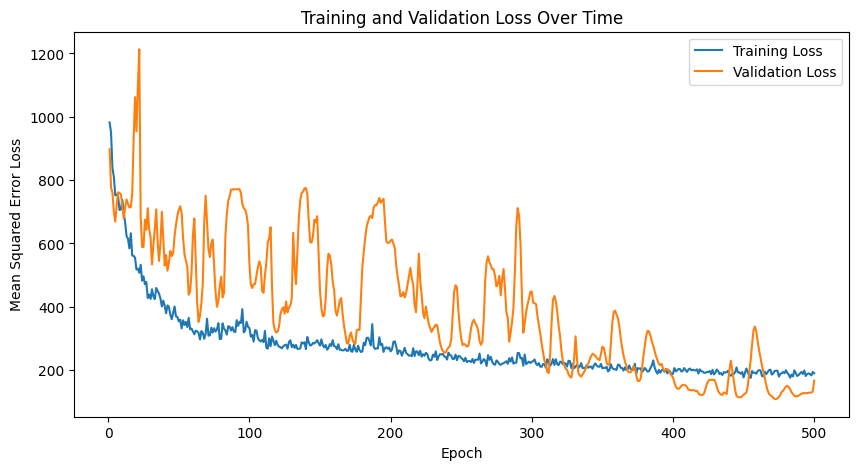

In [302]:
from torch_geometric.nn import GCNConv, BatchNorm

from torch_geometric.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize the model, optimizer, and scheduler
num_features = train_dataset.num_features  # Replace with the number of features in your node feature matrix
num_classes = 2  # For latitude and longitude

model = RobustGCN(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_optimizer)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)  # Assuming StepLR, you can replace this

# Training loop
train_loss_values = []
val_loss_values = []
num_epoch = 500
for epoch in tqdm(range(num_epoch), desc="Training", unit="epoch"):  # 300 epochs
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)  # Using Mean Squared Error loss for regression
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Update the learning rate
    scheduler.step()

    #print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Test loop
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epoch+1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epoch+1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()



### GraphSage


1. Deeper Network: Added more GraphSAGE layers.
2. Batch Normalization: Used to normalize the activations.
3. Skip Connections: Added to help the gradient flow.
4. Different Activation Functions: Used Leaky ReLU.
5. Regularization: Added L2 regularization to the fully connected layers.

To use L2 regularization during training, there is a need to add the regularization loss the main loss as follows:

```python
weight_decay = 0.01  
loss = F.mse_loss(out, batch.y) + model.get_reg_loss(weight_decay)
```


In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.fc(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class AdvancedGraphSAGE(nn.Module):
    def __init__(self, num_features, num_classes):
        super(AdvancedGraphSAGE, self).__init__()

        self.conv1 = SAGEConv(num_features, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.conv2 = SAGEConv(128, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = SAGEConv(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.conv4 = SAGEConv(64, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc = nn.Linear(64, num_classes)

        self.reg_loss = nn.MSELoss()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Layer 1
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        # Layer 2 with skip connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2 + x1)
        x2 = F.dropout(x2, p=0.5, training=self.training)

        # Layer 3
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.leaky_relu(x3)
        x3 = F.dropout(x3, p=0.5, training=self.training)

        # Layer 4 with skip connection
        x4 = self.conv4(x3, edge_index)
        x4 = self.bn4(x4)
        x4 = F.leaky_relu(x4 + x3)
        x4 = F.dropout(x4, p=0.5, training=self.training)

        # Fully connected layer
        out = self.fc(x4)

        return out

    def get_reg_loss(self, weight_decay):
        reg_loss = 0.0
        for param in self.fc.parameters():
            reg_loss += self.reg_loss(param, torch.zeros_like(param))
        return weight_decay * reg_loss


#### Hyperparameters fine tuning

In [ ]:
from torch_geometric.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize the model, optimizer, and scheduler
num_features = train_dataset.num_features  # Replace with the number of features in your node feature matrix
num_classes = 2  # For latitude and longitude

model = AdvancedGraphSAGE(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_optimizer)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)  # Assuming StepLR, you can replace this

# Training loop
train_loss_values = []
val_loss_values = []

for epoch in tqdm(range(300), desc="Training", unit="epoch"):  # 300 epochs
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)  # Using Mean Squared Error loss for regression
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Update the learning rate
    scheduler.step()

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Test loop
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 301), train_loss_values, label='Training Loss')
plt.plot(range(1, 301), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


### GAT Model

#### Simple GAT Model

In [303]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 128, heads=4, concat=True)
        self.conv2 = GATConv(128 * 4, 64, heads=4, concat=True)
        self.fc = torch.nn.Linear(64 * 4, num_classes)  # num_classes is 2 for latitude and longitude

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        # Fully connected layer
        x = self.fc(x)

        return x


##### Hyperparameters fine-tuning

In [304]:
def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    num_heads = trial.suggest_int("num_heads", 1, 8)
    num_epochs = trial.suggest_int("num_epochs", 50, 200)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Initialize and train your model here
    model = GAT(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate your model here
    model.eval()
    with torch.no_grad():
        predictions = model(test_dataset[0]).cpu().numpy()
        labels = test_dataset[0].y.cpu().numpy()
        mae = mean_absolute_error(labels, predictions)

    return mae

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print(f"Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-27 15:26:28,890] A new study created in memory with name: no-name-eb3ba49f-0668-4a50-9e45-4da10dde9355
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2023-09-27 15:26:30,139] Trial 0 finished with value: 12.926971435546875 and parameters: {'lr': 0.0002903595487403773, 'dropout': 0.46881094539627666, 'num_heads': 7, 'num_epochs': 71, 'batch_size': 16}. Best is trial 0 with value: 12.926971435546875.
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2023-09-27 15:26:32,530] Trial 1 finished with value: 13.375064849853516 and parameters: {'lr': 0.05387510847980975, 'dropout': 0.2144768553544583, 'num_heads': 2, 'num_epochs': 143, 'batch_size': 64}. Best is trial 0 with value: 12.926971435546875.
/usr/local/lib/python3.10/dist

Number of finished trials: 100
Best trial:
Value: 1.876359462738037
Params: 
    lr: 0.005598489571238161
    dropout: 0.6308090826000773
    num_heads: 8
    num_epochs: 179
    batch_size: 16


##### Training, Validatation and Testing

Epoch 1, Validation Loss: 764.2568359375
Epoch 2, Validation Loss: 757.72802734375
Epoch 3, Validation Loss: 741.50732421875
Epoch 4, Validation Loss: 747.1117553710938
Epoch 5, Validation Loss: 711.9429321289062
Epoch 6, Validation Loss: 689.39306640625
Epoch 7, Validation Loss: 662.2972412109375
Epoch 8, Validation Loss: 654.6044311523438
Epoch 9, Validation Loss: 768.4866943359375
Epoch 10, Validation Loss: 751.2456665039062
Epoch 11, Validation Loss: 664.2169189453125
Epoch 12, Validation Loss: 848.6822509765625
Epoch 13, Validation Loss: 644.5471801757812
Epoch 14, Validation Loss: 619.2442626953125
Epoch 15, Validation Loss: 614.6798095703125
Epoch 16, Validation Loss: 587.637451171875
Epoch 17, Validation Loss: 643.3941650390625
Epoch 18, Validation Loss: 685.2921752929688
Epoch 19, Validation Loss: 633.343994140625
Epoch 20, Validation Loss: 596.6073608398438
Epoch 21, Validation Loss: 597.7876586914062
Epoch 22, Validation Loss: 588.0406494140625
Epoch 23, Validation Loss: 628

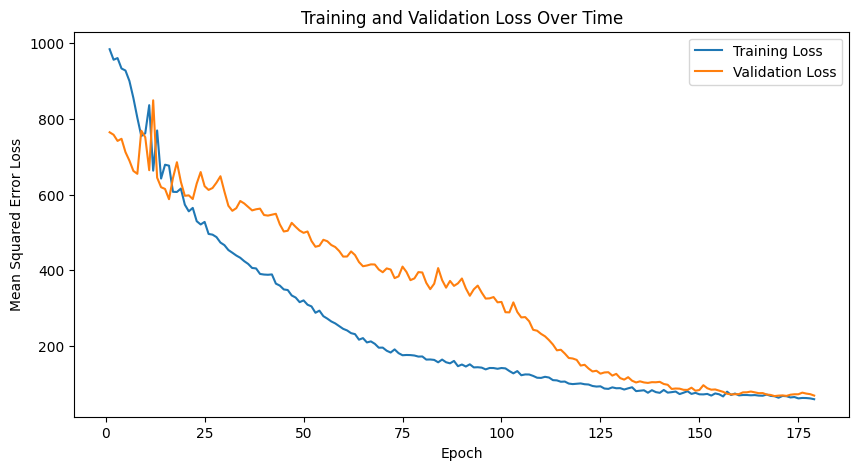

In [306]:
import matplotlib.pyplot as plt

# Best hyperparameters from Optuna
best_lr = trial.params['lr']
best_dropout = trial.params['dropout']
best_num_heads = trial.params['num_heads']
best_num_epochs = trial.params['num_epochs']
best_batch_size = trial.params['batch_size']

# Initialize model and optimizer with best hyperparameters
model = GAT(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(best_num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model(batch)
            val_loss += F.mse_loss(out, batch.y).item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")

# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        test_loss += F.mse_loss(out, batch.y).item()
print(f"Test Loss: {test_loss / len(test_loader)}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, best_num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


#### Robust GAT


1. More layers to capture complex features.
2. Batch normalization to normalize the activations.
3. Skip connections to help the gradient flow.
4. Leaky ReLU activation functions.


In [56]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm

class RobustGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, n_hidden=128, num_heads=2, dropout_rate=0.5):
        super(RobustGAT, self).__init__()

        self.conv1 = GATConv(num_features, n_hidden, heads=num_heads)
        self.batch_norm1 = torch.nn.BatchNorm1d(n_hidden * num_heads)

        self.conv2 = GATConv(n_hidden * num_heads, n_hidden, heads=num_heads)
        self.batch_norm2 = torch.nn.BatchNorm1d(n_hidden * num_heads)

        # Latitude and Longitude regression layers
        self.fc_coordinates_1 = torch.nn.Linear(n_hidden * num_heads, 256)
        self.fc_coordinates_2 = torch.nn.Linear(256, 128)
        self.fc_coordinates_3 = torch.nn.Linear(128, num_classes)

        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm_coordinates = torch.nn.BatchNorm1d(256)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GAT layer
        x1 = F.leaky_relu(self.conv1(x, edge_index))
        x1 = self.batch_norm1(x1)
        x1 = self.dropout(x1)

        # Second GAT layer
        x2 = F.leaky_relu(self.conv2(x1, edge_index))
        x2 = self.batch_norm2(x2)
        x2 = self.dropout(x2)

        # Skip Connection
        x = x1 + x2

        # Latitude and Longitude regression
        coordinates = F.leaky_relu(self.fc_coordinates_1(x))
        coordinates = self.batch_norm_coordinates(coordinates)
        coordinates = self.dropout(coordinates)

        coordinates = F.leaky_relu(self.fc_coordinates_2(coordinates))
        coordinates = self.fc_coordinates_3(coordinates)

        return coordinates


##### Hyperparameters fin tuning

In [58]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    n_hidden = trial.suggest_int("n_hidden", 64, 256)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 10, 100)

    # Initialize and train the model
    model = RobustGAT(num_features, num_classes, n_hidden=n_hidden, num_heads=num_heads, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Assuming train_dataset is your training dataset

    for epoch in range(num_epochs):
        model.train()
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)  # Assuming a regression problem; change the loss function if needed
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Assuming val_loader is your validation DataLoader
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print(f"Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-27 23:13:08,509] A new study created in memory with name: no-name-c61c0825-3df7-4916-a74d-9a99ce8ec3b9
[I 2023-09-27 23:13:11,574] Trial 0 finished with value: 39.76555633544922 and parameters: {'lr': 0.003661467309021371, 'dropout_rate': 0.23190853748932488, 'n_hidden': 76, 'n_heads': 4, 'batch_size': 16, 'num_epochs': 89}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:12,873] Trial 1 finished with value: 774.6070556640625 and parameters: {'lr': 4.9722961912944265e-05, 'dropout_rate': 0.4695465424322689, 'n_hidden': 202, 'n_heads': 1, 'batch_size': 16, 'num_epochs': 20}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:14,056] Trial 2 finished with value: 2072.273681640625 and parameters: {'lr': 0.05428193170395372, 'dropout_rate': 0.43520423691122667, 'n_hidden': 95, 'n_heads': 3, 'batch_size': 64, 'num_epochs': 15}. Best is trial 0 with value: 39.76555633544922.
[I 2023-09-27 23:13:18,575] Trial 3 finished with value: 70.461959838867

Number of finished trials: 100
Best trial:
Value: 18.23297882080078
Params: 
    lr: 0.013291683644311795
    dropout_rate: 0.12123154773047086
    n_hidden: 141
    n_heads: 3
    batch_size: 64
    num_epochs: 97


In [59]:
# Best hyperparameters from Optuna
best_lr = trial.params['lr']
best_dropout_rate = trial.params['dropout_rate']
best_num_heads = trial.params['num_heads']
best_num_epochs = trial.params['num_epochs']
best_batch_size = trial.params['batch_size']

##### Training, validation and testing

Epoch: 1, Train Loss: 982.1267700195312, Val Loss: 774.6909790039062
Epoch: 2, Train Loss: 975.1275634765625, Val Loss: 774.1211547851562
Epoch: 3, Train Loss: 967.927001953125, Val Loss: 773.2579956054688
Epoch: 4, Train Loss: 958.1751098632812, Val Loss: 771.9039916992188
Epoch: 5, Train Loss: 945.9752807617188, Val Loss: 769.8113403320312
Epoch: 6, Train Loss: 930.95947265625, Val Loss: 766.6473999023438
Epoch: 7, Train Loss: 915.4461059570312, Val Loss: 762.1891479492188
Epoch: 8, Train Loss: 896.9086303710938, Val Loss: 756.362548828125
Epoch: 9, Train Loss: 878.4078979492188, Val Loss: 749.220947265625
Epoch: 10, Train Loss: 856.5610961914062, Val Loss: 740.7860717773438
Epoch: 11, Train Loss: 835.729248046875, Val Loss: 731.3019409179688
Epoch: 12, Train Loss: 813.9197998046875, Val Loss: 720.6705322265625
Epoch: 13, Train Loss: 788.8885498046875, Val Loss: 708.8673706054688
Epoch: 14, Train Loss: 768.8761596679688, Val Loss: 695.9082641601562
Epoch: 15, Train Loss: 740.99621582

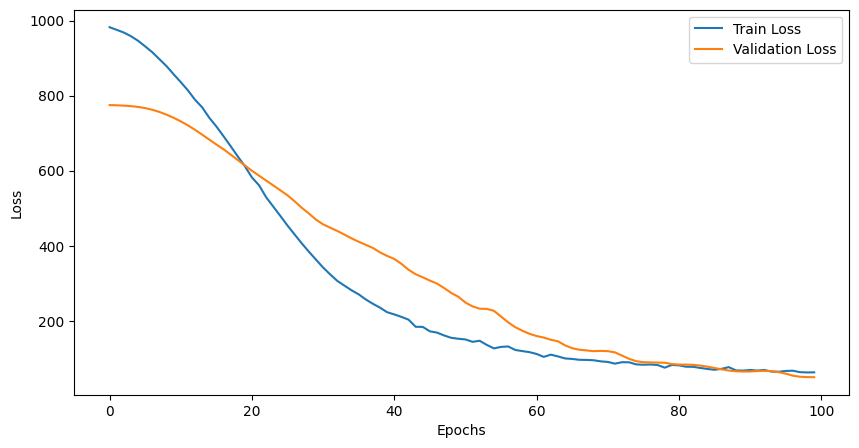

In [61]:
# Initialize model_rGAT, optimizer, and other settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rGAT = RobustGAT(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model_rGAT.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # Assuming a regression problem

train_losses = []
val_losses = []

# Training Loop
for epoch in range(100):
    model_rGAT.train()
    train_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model_rGAT(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Loop
    model_rGAT.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model_rGAT(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##### Prediction on test data

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

test_data = test_dataset.get(0).to(device)

model_rGAT.eval()
with torch.no_grad():
    predictions = model_rGAT(test_data).cpu().numpy()
    labels = test_data.y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions)

print(f"MAE: {mae}, \nMSE: {mse}, \nRMSE: {rmse}, \nR-Squared: {r2}")


MAE: 2.4757726192474365, 
MSE: 49.74394226074219, 
RMSE: 7.052938461303711, 
R-Squared: 0.9224942192010799


In [66]:

# Calculate Haversine distances for all nodes
haversine_distances_rGAT = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions)])

mean_distance = np.mean(haversine_distances_rGAT)
median_distance = np.median(haversine_distances_rGAT)
std_dev = np.std(haversine_distances_rGAT)
min_distance = np.min(haversine_distances_rGAT)
max_distance = np.max(haversine_distances_rGAT)
quartiles = np.percentile(haversine_distances_rGAT, [25, 50, 75])
skewness = stats.skew(haversine_distances_rGAT)
kurtosis = stats.kurtosis(haversine_distances_rGAT)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 421.8275418126723, Median: 48.1084854656073, Std Dev: 950.2910874710302
Min: 0.6515818644370696, Max: 10878.588734087043
Quartiles: [  9.94836771  48.10848547 506.20020976]
Skewness: 5.553197168161972, Kurtosis: 42.534006479717156


# CLASSIFIER